# Train model

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from load_qm9 import *
from display_mol import *

#load dataset
ds = qm9_load_torch()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:1


In [ ]:
#convertir dataser to int 32 and float 32 to reduce memory usage and save it as a .pt file
for i in range(len(ds)):
    coords, elements, charges = ds[i]
    coords = coords.to(torch.float32)
    elements = elements.to(torch.int32)
    charges = charges.to(torch.float32)
    ds[i] = (coords, elements, charges)

torch.save(ds, "./data/QM9/qm9_torch.pt")




In [17]:
ds=qm9_load_torch()

In [28]:
for i in range(len(ds)):
    coords, elements, charges = ds[i]
    coords.to(device)
    elements.to(device)
    charges.to(device)

## data management and preprocessing

### Moldecule dataloader for trainning in batchs of equal size

In [29]:
ATOM_TYPES = [1, 6, 7, 8, 9]
MAX_SIZE = 30 # max number of atoms per molecules


class MoleculeDataset:
    def __init__(self, dataset):
        self.ds = dataset
        self.N = len(dataset)
        self.M_pdf = np.zeros(MAX_SIZE, dtype=np.int32)
        self.molecules_by_size = {i: [] for i in range(MAX_SIZE)}
        
        self._index_molecules()
        
        print(f"Dataset chargé : {self.N} molécules")
        print(f"Distribution des tailles : {self.M_pdf}")
    

    def _index_molecules(self):
        for idx, example in enumerate(self.ds):
            n_atoms = example[1].shape[0]
            self.M_pdf[n_atoms] += 1
            self.molecules_by_size[n_atoms].append(idx)
    
    
    def get_batch(self, batch_size): 
        """
        return generator that give infinite patchs with molecules of equal sizes
        """ 
        valid_sizes = [M for M in range(MAX_SIZE) if self.M_pdf[M] >= batch_size]

        valid_probs = np.array([self.M_pdf[M] for M in valid_sizes])
        valid_probs = valid_probs / valid_probs.sum() 
        
        while True:
            M = np.random.choice(valid_sizes, p=valid_probs)
            
            available_indices = self.molecules_by_size[M]
            
            selected_indices = np.random.choice( # shuffle
                    available_indices, 
                    size=batch_size, 
                    replace=False
                )
            
            batch = [self.ds[idx] for idx in selected_indices]
            
            yield self._collate_batch(batch)
    
    def _collate_batch(self, batch):
        """
        Combine une liste de molécules en un batch.
        """
        x = torch.stack([mol[0] for mol in batch], dim=0)
        y = torch.stack([mol[1] for mol in batch], dim=0)
        q = torch.stack([mol[2] for mol in batch], dim=0)
        
        return [x, y, q]
    
    def get_epoch_batches(self, batch_size):
        """
        Génère des batches pour une époque complète.
        Chaque molécule apparaît exactement une fois par époque.
        """
        all_batches = []
        
        for M in range(MAX_SIZE):
            if self.M_pdf[M] == 0:
                continue
            
            indices = self.molecules_by_size[M].copy()
            
            np.random.shuffle(indices)
            
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i + batch_size]
                if len(batch_indices) == batch_size:
                    batch = [self.molecules_list[idx] for idx in batch_indices]
                    all_batches.append(batch)
        
        np.random.shuffle(all_batches)
        
        for batch in all_batches:
            yield self._collate_batch(batch)
    

molecules = MoleculeDataset(ds) # ~1min30


Dataset chargé : 133885 molécules
Distribution des tailles : [    0     0     0     2     4     5    12    21    70   193   527  1150
  2336  4259  7103 10646 14270 17394 17836 18336 12601 13189  4483  6362
   713  1923    59   356     0    35]


In [30]:


# Génération infinie de batches (pour l'entraînement)
batch_gen = molecules.get_batch(batch_size=2)

for i in range(5):
    batch = next(batch_gen)
    print([i.shape for i in batch])


[torch.Size([2, 16, 3]), torch.Size([2, 16]), torch.Size([2, 16])]
[torch.Size([2, 15, 3]), torch.Size([2, 15]), torch.Size([2, 15])]
[torch.Size([2, 15, 3]), torch.Size([2, 15]), torch.Size([2, 15])]
[torch.Size([2, 17, 3]), torch.Size([2, 17]), torch.Size([2, 17])]
[torch.Size([2, 20, 3]), torch.Size([2, 20]), torch.Size([2, 20])]


### one hot encoding for the molecule shape

In [31]:
def one_hot_encode(batch):
    x = batch[0]
    x -= torch.mean(x, axis=1)[:, None, :]
    e = batch[1]
    q = batch[2]
    
    max_atom_type = max(ATOM_TYPES) + 1
    lookup = torch.full((max_atom_type,), -1, dtype=torch.long)
    
    for idx, atom_type in enumerate(ATOM_TYPES):
        lookup[atom_type] = idx
    
    y_indices = lookup[e]
    
    assert (y_indices >= 0).all(), "Types d'atomes inconnus détectés!"
    
    
    e = torch.nn.functional.one_hot(y_indices, num_classes=len(ATOM_TYPES)).float()
    
    return [x, e, q]

def one_hot_decode(batch):
    x = batch[0].clone().detach()
    e_onehot = batch[1].clone().detach()
    q = batch[2].clone().detach()
    
    e_indices = torch.argmax(e_onehot, dim=-1)  # (batch_size, n_atoms)
    atom_types_tensor = torch.tensor(ATOM_TYPES, dtype=torch.long)
    e = atom_types_tensor[e_indices]
    
    return [x, e, q]



def one_hot_decode_stochastic(batch, temperature=1.0):
    x = batch[0].clone().detach()
    e_soft = batch[1].clone().detach()
    q = batch[2].clone().detach()
    
    # Option 2: Sampling selon les probabilités (stochastic)
    e_probs = torch.nn.functional.softmax(e_soft / temperature, dim=-1)
    e_indices = torch.multinomial(
        e_probs.view(-1, e_probs.size(-1)), 
        num_samples=1
    ).view(e_probs.shape[:-1])
    
    atom_types_tensor = torch.tensor(ATOM_TYPES, dtype=torch.long)
    e = atom_types_tensor[e_indices]
    
    return [x, e, q]
    

mol = one_hot_encode(next(batch_gen))   
print([e.shape for e in mol])
print([e.shape for e in one_hot_decode(mol)])

[torch.Size([2, 16, 3]), torch.Size([2, 16, 5]), torch.Size([2, 16])]
[torch.Size([2, 16, 3]), torch.Size([2, 16]), torch.Size([2, 16])]


## Model

In [ ]:
class UltraMagaDiffusion(torch.nn.Module):
    def __init__(self):
        super(UltraMagaDiffusion, self).__init__()
        self.T = 1000
        s = 1e-5
        self.alpha = [(1-2*s)*(1 - (t/self.T)**2)+s for t in range(self.T+1)]
        self.omega = [1-alpha**2 for alpha in self.alpha]
        self.L = 9
        self.lr = 1e-4
        self.num_class = len(ATOM_TYPES)

        self.init_weight()
    
    def init_weight(self):
        self.phi_e = torch.nn.ModuleList()
        self.phi_inf = torch.nn.ModuleList()
        self.phi_x = torch.nn.ModuleList()
        self.phi_h = torch.nn.ModuleList()

        nf = self.num_class + 2  # +2 for atom charge and t/T

        for l in range(self.L):
            self.phi_e.append(torch.nn.Sequential(
                torch.nn.Linear(nf * 2 + 2, nf), 
                torch.nn.SiLU(),
                torch.nn.Linear(nf, nf),
                torch.nn.SiLU(),
            ))

            self.phi_inf.append(torch.nn.Sequential(
                torch.nn.Linear(nf, 1),
                torch.nn.Sigmoid(),
            ))

            self.phi_x.append(torch.nn.Sequential(
                torch.nn.Linear(nf * 2 + 2, nf),
                torch.nn.SiLU(),
                torch.nn.Linear(nf, nf),
                torch.nn.SiLU(),
                torch.nn.Linear(nf, 1),
            ))

            self.phi_h.append(torch.nn.Sequential(
                torch.nn.Linear(nf * 2, nf),
                torch.nn.SiLU(),
                torch.nn.Linear(nf, nf),
            ))
        
    
    def forward(self, mols, t):
        (x, e, q) = mols 
        h = torch.cat([e, q[:, :, None], torch.ones_like(q)[:, :, None]*t[:, :, None]/self.T], dim=-1)
        x0 = x.clone()
        e0 = e.clone()
        q0 = q.clone()

        N = h.shape[1]
        diff = x[:, :, None, :] - x[:, None, :, :]   # (B, N, N, 3)
        a_ij = torch.sqrt(torch.sum(diff ** 2, dim=-1))[:, :, :, None]  # (B, N, N, 1)
        for l in range(self.L):
            diff = x[:, :, None, :] - x[:, None, :, :]   # (B, N, N, 3)
            d_ij = torch.sqrt(torch.clamp(torch.sum(diff ** 2, dim=-1), min=1e-9))[:, :, :, None]  # (B, N, N, 1) distance squared matrix
        
            
            # compute m_ij
            h_i = h[:, :, None, :].expand(-1, N, N, -1)  # (B, N, N, d)
            h_j = h[:, None, :, :].expand(-1, N, N, -1)  # (B, N, N, d)

            features = torch.cat([h_i, h_j, d_ij, a_ij], dim=-1)  # (B, N, N, 2d+2)
            m_ij = self.phi_e[l](features)  # (B, N, N, d)

            # compute e_ij
            e_ij = self.phi_inf[l](m_ij) # (B, N, N, 1)

            # update x
            weights = self.phi_x[l](features) * diff / (d_ij + 1.0)  # (B, N, N, 3)
            x = x + weights.sum(dim=2)                          # (B, N, 3)
            

            # update h
            mask = ~torch.eye(N, dtype=bool, device=device)[None, :, :, None]  # (1, N, N, 1)
            agg = (e_ij * mask * m_ij).sum(dim=2)   # (B, N, d)
            h = h + self.phi_h[l](torch.cat([h, agg], dim=-1))   # (B, N, d)
    
        x = x - x0 # (B, N, 3)
        x = x - torch.mean(x, axis=1)[:, None, :] # (B, 1, 3)
        e, q = h[:, :, :self.num_class]-e0, h[:, :, self.num_class]-q0
        return (x, e, q)
    

    def training_step(self, batch, optimizer):
        self.train()
        optimizer.zero_grad()

        x, e, q = batch
        B = x.shape[0]
        e = e * 0.25  # h_onehot
        q = q * 0.1   # h_atom_charge

        t = torch.randint(1, self.T + 1, (B, 1), device=device).float() # Random timestep per batch
        eps_x = torch.randn_like(x, device=device) # (B, N, 3)
        eps_e = torch.randn_like(e, device=device) # (B, N, D)
        eps_q = torch.randn_like(q, device=device) # (B, N)

        eps_x = eps_x - torch.mean(eps_x, dim=1, keepdim=True)
        

        # Diffusion step: add noise to x0
        alpha_t = torch.tensor(self.alpha,device=device)[t.long()].view(B, 1, 1)
        omega_t = torch.sqrt(torch.tensor(self.omega,device=device))[t.long()].view(B, 1, 1)
        x_t = alpha_t * x + omega_t * eps_x
        e_t = alpha_t * e + omega_t * eps_e
        q_t = alpha_t.squeeze(-1) * q + omega_t.squeeze(-1) * eps_q

        # Predict denoised offset (model learns to predict ε)
        eps_x_pred, eps_e_pred, eps_q_pred = self.forward((x_t, e_t, q_t), t)
        
        # Reconstruction loss (denoising loss)
        loss_x = torch.nn.functional.mse_loss(eps_x_pred, eps_x)
        loss_e = torch.nn.functional.mse_loss(eps_e_pred, eps_e)
        loss_q = torch.nn.functional.mse_loss(eps_q_pred, eps_q)

        loss = loss_x +loss_e + loss_q 
        loss.backward()
        #print("====3debug :", torch.max(loss))
        optimizer.step()
        #print("====3debug :", torch.max(self.phi_x[0][0].weight))

        return {
            'loss': loss.detach().cpu().item(),
            'loss_x': loss_x.detach().cpu().item(),
            'loss_e': loss_e.detach().cpu().item(),
            'loss_q': loss_q.detach().cpu().item(),
        }


    @torch.no_grad()
    def sample(self, batch_size, N):
        self.eval()

        # Initialize x_T from Gaussian noise
        x = torch.randn(batch_size, N, 3, device=device)
        e = torch.randn(batch_size, N, self.num_class, device=device)
        q = torch.randn(batch_size, N, device=device)

        for t in reversed(range(1, self.T + 1)):
            t_tensor = torch.full((batch_size, 1), t, device=device).float()
            dx, de, dq = self.forward((x, e, q), t_tensor)

            # Compute coefficients
            alpha_t = torch.tensor(self.alpha[t], device=device).view(1, 1, 1)
            omega_t = torch.tensor(self.omega[t], device=device).view(1, 1, 1)
            alpha_s = torch.tensor(self.alpha[t-1], device=device).view(1, 1, 1)
            omega_s = torch.tensor(self.omega[t-1], device=device).view(1, 1, 1)

            alpha_ts = alpha_t/alpha_s
            omega_ts = omega_t - alpha_ts**2 * omega_s
            omega_t_s = torch.sqrt(omega_ts * omega_s / omega_t)
            # Reverse diffusion step
            if t>1:
                eps_x = torch.randn_like(x, device=device)
                eps_x= eps_x - torch.mean(eps_x, dim=1, keepdim=True)

                eps_e = torch.randn_like(e, device=device)

                eps_q = torch.randn_like(q, device=device)

            else :
                eps_x = 0.0
                eps_e = 0.0
                eps_q = 0.0


            x = x / alpha_s - omega_ts/(alpha_ts*torch.sqrt(omega_t)) * dx + omega_t_s * eps_x
            e = e / alpha_s - omega_ts/(alpha_ts*torch.sqrt(omega_t)) * de + omega_t_s * eps_e
            q = q / alpha_s.squeeze(-1) - (omega_ts/(alpha_ts*torch.sqrt(omega_t))).squeeze(-1) * dq + omega_t_s.squeeze(-1) * eps_q
        return x, e, q




model = UltraMagaDiffusion().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=model.lr)
batch_gen = molecules.get_batch(batch_size=64)
#torch.autograd.set_detect_anomaly(True)
max_iter = 10000
loss = []
for i in range(max_iter):
    batch = one_hot_encode(next(batch_gen))
    batch = [v.to(device) for v in batch]
    logs = model.training_step(batch, optimizer)
    print(f"\r{i+1}/{max_iter}", end="")
    if i % 200 == 0: 
        print(logs)
    loss += [logs['loss']]

# Sampling
#x_gen, e_gen, q_gen = model.sample(batch_size=8, N=9)


1/10000{'loss': 6.085815906524658, 'loss_x': 5.172235012054443, 'loss_e': 2.3279099464416504, 'loss_q': 3.316035032272339}
201/10000{'loss': 0.7990631461143494, 'loss_x': 0.6745043396949768, 'loss_e': 0.3641529083251953, 'loss_q': 0.3352057933807373}
401/10000{'loss': 0.6841380000114441, 'loss_x': 0.6006150841712952, 'loss_e': 0.26098620891571045, 'loss_q': 0.1827639639377594}
601/10000{'loss': 0.6153514981269836, 'loss_x': 0.5407347083091736, 'loss_e': 0.23654460906982422, 'loss_q': 0.15480609238147736}
801/10000{'loss': 0.5823355317115784, 'loss_x': 0.5197513699531555, 'loss_e': 0.20291204750537872, 'loss_q': 0.11856142431497574}
1001/10000{'loss': 0.545925498008728, 'loss_x': 0.48484548926353455, 'loss_e': 0.1934327334165573, 'loss_q': 0.12721842527389526}
1201/10000{'loss': 0.5683626532554626, 'loss_x': 0.5022323131561279, 'loss_e': 0.213266059756279, 'loss_q': 0.12813806533813477}
1401/10000{'loss': 0.528266966342926, 'loss_x': 0.48240959644317627, 'loss_e': 0.14808543026447296, '

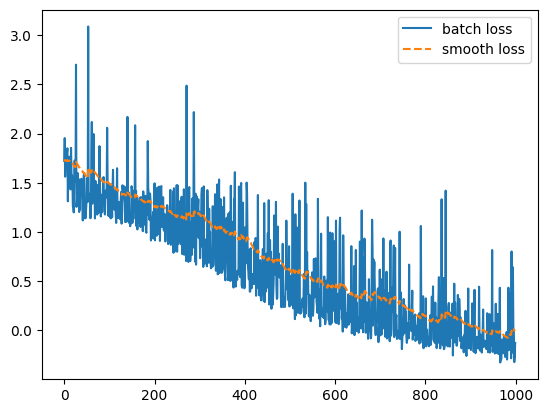

In [50]:
plt.plot(np.log(loss), label='batch loss')
beta = 0.97
ema = []
avg = loss[0]
for l in loss:
    avg = beta * avg + (1 - beta) * l
    ema.append(avg)
plt.plot(np.log(ema), '--', label='smooth loss')

plt.legend()

[tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]), tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])]


(<Figure size 1000x800 with 1 Axes>, <Axes3D: title={'center': 'Molécule'}>)

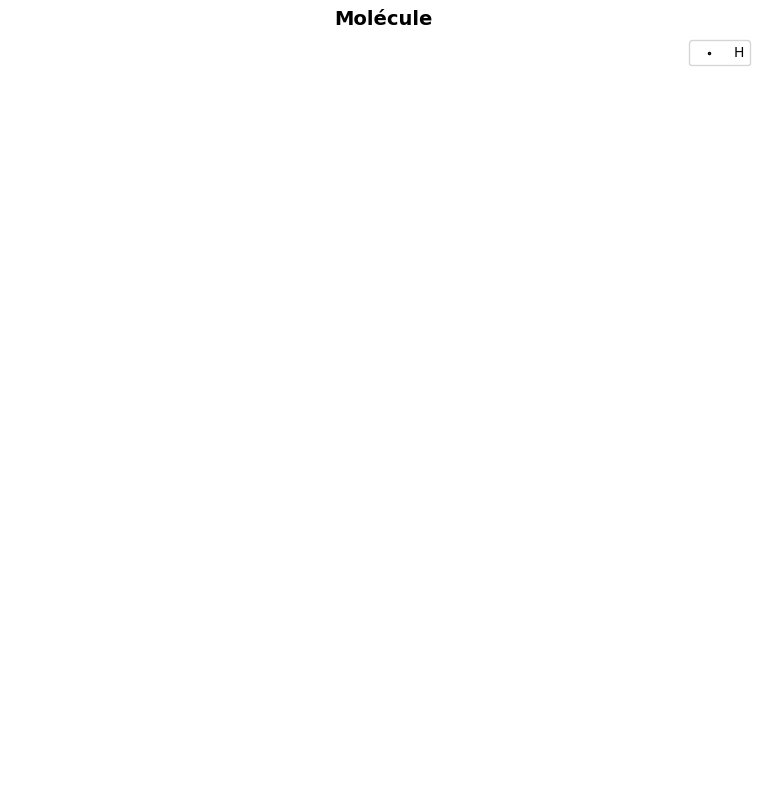

In [52]:
# sample a single molecule (batch=1, N=9)
s = model.sample(1, 9)

# move tensors to CPU before decoding to avoid device mismatch
s_cpu = [a[0].cpu() for a in s]  # take first sample from batch and move to cpu
mol = one_hot_decode(s_cpu)

print(mol)
plot_molecule(mol_to_dict(mol))

In [43]:
with torch.no_grad():
    batch = one_hot_encode(next(batch_gen))
    x, e, q = batch
    B = x.shape[0]

    t = torch.randint(5, 5 + 1, (B, 1), device=device).float() # Random timestep per batch
    eps_x = torch.randn_like(x, device=device) # (B, N, 3)
    eps_e = torch.randn_like(e, device=device) # (B, N, D)
    eps_q = torch.randn_like(q, device=device) # (B, N)

    # Diffusion step: add noise to x0
    alpha_t = torch.tensor(model.alpha,device=device)[t.long()].view(B, 1, 1)
    omega_t = torch.sqrt(torch.tensor(model.omega,device=device))[t.long()].view(B, 1, 1)
    x_t = alpha_t * x.to(device) + omega_t * eps_x
    e_t = alpha_t * e.to(device) + omega_t * eps_e
    q_t = alpha_t.squeeze(-1) * q.to(device) + omega_t.squeeze(-1) * eps_q

    # Predict denoised offset (model learns to predict ε)
    eps_x_pred, eps_e_pred, eps_q_pred = model.forward((x_t, e_t, q_t), t)
    print(eps_x_pred[0]-eps_x[0])

tensor([[ 0.6042,  0.9219, -0.3754],
        [-0.1161,  0.7098, -0.2347],
        [ 0.1919,  0.5025, -0.9814],
        [ 0.4967,  0.5496, -0.1110],
        [-0.1073, -1.0940, -0.1909],
        [ 0.0699, -0.1645, -0.2488],
        [ 0.4429, -0.3807, -0.4752],
        [-0.1559, -0.6873, -0.6498],
        [-0.3349,  0.1646, -0.6482],
        [-0.2986,  0.5541, -0.2274],
        [ 0.7850,  0.7579, -0.3078],
        [-1.4730,  0.2313, -0.4241],
        [ 0.5913, -0.2490, -0.2900]], device='cuda:1')
